## **«Предварительный анализ данных и построение признаков в задачах распознавания эмоций в тексте»**

**Цель**: Произвести классификацию текстовых данных по классам-эмоциям при помощи инструментов машинного обучения

**Задачи:**
* Реализовать анализ имеющегося набора данных
* Произвести обработку естественного языка
* Выявить наилучшую модель классификации с наиболее выскоими показателями качества обучения модели

**Ожидаемый результат** -- создание модели, которая сможет распознавать эмоциональный окрас текстов. 

**План работы:**
*   Загрузка и описание датасета
*   Предварительный анализ и очистка данных
*   Обработка естественного языка
*   Преобразование текстовых данных в числовые. Векторизация текста
*   Построение моделей классификации
*   Сравнение моделей
*   Улучшение модели
*   Заключение


# Загрузка и описание датасета

## Импорт библиотек

In [4]:
pip install gensim

  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
# from matplotlib.pyplot import bar_label

# обработка естественного языка
from gensim.parsing.preprocessing import remove_stopwords 
import re
import nltk
from nltk.tokenize import word_tokenize   
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

# векторизация текста
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

# модели машинного обучения
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# метрики точности моделей
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

# from yellowbrick.model_selection import LearningCurve

## Описание данных

Загрузим датасет и выведем первые строки, чтобы посмотреть на его содержимое

In [10]:
data = pd.read_csv('C://Users//Admin//Downloads//tweet_emotions.csv')   # загрузка датасета
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [11]:
data.shape    #размерность датасета

(40000, 3)

Датасет содержит $40000$ строк и $3$ столбца

In [12]:
data.dtypes

tweet_id      int64
sentiment    object
content      object
dtype: object

Датасет сожержит $1$ числовой столбец (количественный признак) и $2$ нечисловых (категориальные признаки)




In [13]:
data.columns   # наименования столбцов

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

Датасет содержит $3$ столбца и $40000$ строк \
Столбцы:

*   ```tweet_id```-- id каждого пользователя, оставившего сооющение в твиттере
*  ```sentiment```	-- целевой столбец, определяющий эмоцию в тексте столбца content
*   ```content  ```-- текст-сообщение пользовател в твиттере, у которого необходимо распознать эмоцию


In [14]:
len(data['sentiment'].unique())
# количество уникальных значений в столбце с эмоциями

13

В столбце ```sentiment``` сожержится 13 уникальных значений => имеется $13$ классов эмоций, по которым предстоит проклассифицировать текст

>**Решаемая проблема** -- множество объектов текста разделить на $13$ классов эмоций (**задача классификации текста**), и обработки естественного языка. Задача классификации относится к задачам обучения с учителем, поскольку нам заранее известен результат, который мы хотим получить.

# Предварительный анализ и очистка данных

Для построения более точных и качественных моделей изучим и проанализируем данные

In [15]:
data.describe()   # описательная статистика, основная статистическая информация об атрибутах (по столбцу tweet_id, тк только он сожержит числовые данные)

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


Столбец ```tweet_id``` представляет количественную харкатеристику датасета

In [16]:
data[['sentiment']].describe()

,sentiment
count,40000
unique,13
top,neutral
freq,8638


In [17]:
 data[['content']].describe()

,content
count,40000
unique,39827
top,I just received a mothers day card from my lov...
freq,14


>Столбцы ```sentiment``` и ```content``` являются категориальными признаками

---
**Значимость каждого из атрибутов для предсказания целевой переменной**
 

*   ```tweet_id``` является лишь идентификатором пользователя, оставившего текст. Данный атрибут не оказывает влияния на целевую переменную ```sentiment```, поскольку нам не важно кто оставил текст, а важно лишь содержимое текста для дальнейшей классификации текстов
*   ```content``` вкслючает в себя текст, который необходимо проклассифицировать по классам $=>$ оказывает влияние на целевую переменную ```sentiment```

Просмотрим датасет на наличие:
* отсутствующих данных;
* неинформативных данных – дубликатов;
* несогласованных данных – одних и тех же данных, представленных в разных регистрах или форматах.

> Проверка датасета на наличие пустых значений:

In [18]:
data.info()   # типы данных, кол-во значений в каждом столбце, тип данных каждого столбца

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [19]:
data.isnull().sum()    # количество пропущенных значений

tweet_id     0
sentiment    0
content      0
dtype: int64

Датасет не содержит пустых (пропущенных) значений => не требует очистки

In [20]:
print(f'''Max length --> {data['content'].str.len().max()},    
Mean length --> {data['content'].str.len().mean()}, 
Min length --> {data['content'].str.len().min()}''')   # максимальная, средняя и минимальная длина текста в датасете в поле content

Max length --> 167,    
Mean length --> 73.40555, 
Min length --> 1


Максимальная длина текстового сообщения $167$, средняя ~ $73$, минимальная -- $1$ символ\
Датасет содержит несколько записей, состоящих из $1$ символа.\
Посмотрим на содержимое данных строк. При отсутсвии смысловой значимости данным удалим эти строки из датасета

In [21]:
data[data['content'].str.len() == 1]    # строки, длина которых = 1

,tweet_id,sentiment,content
340,1957042734,empty,0
15028,1964712204,neutral,0
29869,1751394197,neutral,0
39415,1753819910,neutral,0


Содержимое данных строк $= 0$. Данные записи можно удалить из датасета, поскольку их наличие не имеет смысла для дальнейшей классификации

In [22]:
drop_index = data[data['content'].str.len() == 1].index; drop_index   # индексы строк, сотсоящих из 0, для удаления

Int64Index([340, 15028, 29869, 39415], dtype='int64')

In [23]:
data = data.drop(labels =drop_index, axis = 0); data.head()   # удаление строк по индексам

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [24]:
data['content'].str.len().min(), data[data['content'].str.len() == 1] 

(6,
 Empty DataFrame
 Columns: [tweet_id, sentiment, content]
 Index: [])

In [25]:
data.shape

(39996, 3)

Теперь минимальная длина текстового сообщения $= 6$, столбец больше не содержит записей, содержащих "0".\
Из датасета удалили $4$ строки, поэтому теперь количество строк стало $39996$

> Проверим датасет на наличие неинформативных данных - дубликатов в строках\
Значения столбца ```tweet_id``` не будем учитывать, поскольку его значения всегда уникальны и требуется проверить на дубликаты именно текст пользователй

In [26]:
uniq_counts = pd.DataFrame(
    {
        'tweet_id': len(data['tweet_id'].unique()),
        'sentiment': len(data['sentiment'].unique()),
        'content': len(data['content'].unique()),
    }, index = ['value counts']
)
uniq_counts

,tweet_id,sentiment,content
value counts,39996,13,39826


Можем сделать выввод, что:
*   Каждый ```	tweet_id``` уникален
*   Датафрейм содержит $13$ классов эмоций
* В столбце ```content``` содержатся дубликаты текста, тк количество уникальных значений не равно количествуву строк в датафрейме


In [27]:
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов строк для столбцов эмоция - текст

89

Датасет содержит дубликаты строк (в количестве $89$), которые нужно удалить\
Но для начала просмотрим не имеется ли одинаковых записей в разных регистрах\
Для этого приведем все записи в единому регистру и повторно проверм на наличие дубликатов

In [28]:
# принудительное понижение регистра
data['content'] = data['content'].str.lower()
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов строк для столбцов эмоция - текст

134

Количество дубликатов строк увеличилось. Датасет содержит дубликаты строк (в количестве $134$), которые нужно удалить из датасета

In [29]:
data[data[['sentiment','content']].duplicated() == True]   # строки с дубликатами

,tweet_id,sentiment,content
521,1957088574,worry,somebody please save the polar bears!
6591,1961366316,sadness,headache
6718,1961422696,sadness,headache
8878,1962332251,worry,my throat hurts
9613,1962653254,worry,my tummy hurts
...,...,...,...
39859,1753886681,love,happy mothers day
39898,1753902524,love,happy mothers day!
39913,1753902827,happiness,happy mother's day!
39915,1753903008,love,happy mother's day everyone


In [30]:
drop_index = data[data[['sentiment','content']].duplicated() == True].index   # индексы строк для удаления
drop_index

Int64Index([  521,  6591,  6718,  8878,  9613, 10918, 11800, 12531, 13491,
            14208,
            ...
            39260, 39277, 39284, 39600, 39772, 39859, 39898, 39913, 39915,
            39945],
           dtype='int64', length=134)

In [31]:
data = data.drop(labels =drop_index, axis = 0); data.head()   # удаление строк

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends soon!
4,1956968416,neutral,@dannycastillo we want to trade with someone w...


In [32]:
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов

0

Все дублирующиеся строки были удалены\
Теперь датасет не содержит дублирующихся строк по столбцам ```sentiment - content```

In [33]:
data.shape   # теперь в датасете содержится 39862 записи

(39862, 3)

## Анализ данных


Опрделим, какое количество строк (сколько текстов) относятся к каждому классу эмоций\
Для этого сгруппируем датасет по столбцу ```sentiment```

In [34]:
(data.groupby(['sentiment']))['content'].count()   # соотношение эмоция - кол-во текстов к эмоции

sentiment
anger          110
boredom        179
empty          826
enthusiasm     759
fun           1776
happiness     5183
hate          1323
love          3787
neutral       8606
relief        1524
sadness       5155
surprise      2186
worry         8448
Name: content, dtype: int64

Визуализация и наглядное представление распрделения эмоций. Гистограмма показывает распределение того, как часто в датасете встречается каждая из эмоций (какое количество раз)

(array([ 826., 5155.,  759., 8606., 8448., 2186., 3787., 1776., 1323.,
        5183.,  179., 1524.,  110.]),
 array([ 0.        ,  0.92307692,  1.84615385,  2.76923077,  3.69230769,
         4.61538462,  5.53846154,  6.46153846,  7.38461538,  8.30769231,
         9.23076923, 10.15384615, 11.07692308, 12.        ]),
 <BarContainer object of 13 artists>)

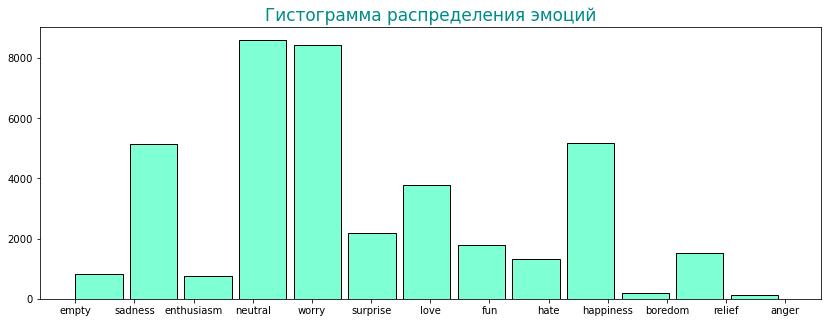

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,5))  # создание рабочей области

ax.set_title('Гистограмма распределения эмоций', color = 'darkcyan', size = 17)   # названия графика
ax.hist(
    data['sentiment'], 
    edgecolor = 'black',  # обводка колонок 
    color ='aquamarine', 
    bins = 13,   # кол-во колонок
    width  = 0.8   # ширина колонок
    ) 

>Наиболее часто встречается класс ```neutral	```\
Самый редкий - ```anger```\
Можно сделать вывод о *несбалансированности* набора данных, тк некоторые классы представлены значительно меньшим количеством данных

In [36]:
frequency = data['sentiment'].value_counts(normalize = True); frequency   # относительная частота каждого класса

neutral       0.215895
worry         0.211931
happiness     0.130024
sadness       0.129321
love          0.095003
surprise      0.054839
fun           0.044554
relief        0.038232
hate          0.033190
empty         0.020721
enthusiasm    0.019041
boredom       0.004490
anger         0.002760
Name: sentiment, dtype: float64

In [37]:
frequency.index   

Index(['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun',
       'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger'],
      dtype='object')

<BarContainer object of 13 artists>

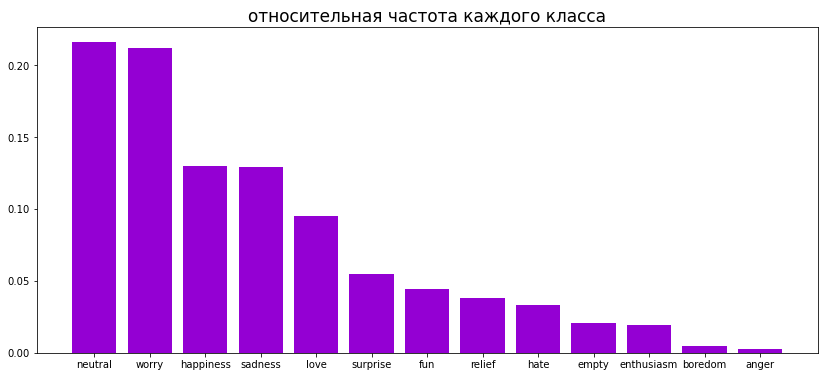

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,6))  # создание рабочей области

ax.set_title('относительная частота каждого класса', color = 'black', size = 17)   # названия графика
ax.bar(frequency.index, frequency, color = 'darkviolet')

# ax.bar_label(ax.containers[0], label_type='edge')

Вычисление относительной частоты показало аналогичные результаты

---

Проанализируем поле ```content``` по длине символов





In [47]:
text_length = data['content'].str.len(); text_length    #длина каждого текстового сообщения

0         92
1         60
2         35
3         36
4         86
        ... 
39995     16
39996     30
39997    123
39998    122
39999    132
Name: content, Length: 39862, dtype: int64

In [48]:
text_length.describe()   # описательная статистика 

count    39862.000000
mean        73.535021
std         36.492918
min          6.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: content, dtype: float64

Максимальное значение длины текста $= 167$, медианное значение $= 73$. Это говорит о том, что в наборе данных присутствует незначительная асимметрия

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='content'>

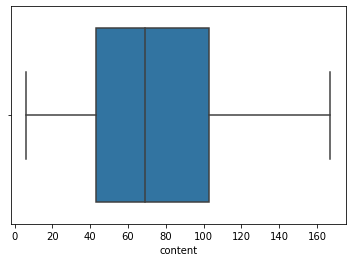

In [49]:
sns.boxplot(text_length)

На графике видно, что максимальное значение чуть больше $160$, минимальное ~ $6$,среднее значение колеблется около $70$. Выбросов (сильно выбивающихся значений) не имеется

Посмотрим среднее количество слов текста для каждой категории

In [50]:
words = data['content'].apply(lambda x: len(x.split())); words   # количество слов в каждой строке поля сontent

0        18
1        10
2         3
3         7
4        15
         ..
39995     1
39996     6
39997    25
39998    19
39999    18
Name: content, Length: 39862, dtype: int64

In [51]:
new_data = data.copy()
new_data['content'] = words
new_data.head()   # новый датасет, у которого текст заменен на количество слов в тексте

,tweet_id,sentiment,content
0,1956967341,empty,18
1,1956967666,sadness,10
2,1956967696,sadness,3
3,1956967789,enthusiasm,7
4,1956968416,neutral,15


In [52]:
mean_word = pd.DataFrame(new_data.groupby(['sentiment'])['content'].mean()); mean_word    # среднее значение количества слов в тексте для каждой категории

,content
sentiment,
anger,14.100000
boredom,13.603352
empty,11.473366
enthusiasm,13.426877
fun,14.390203
happiness,13.410380
hate,14.360544
love,13.303670
neutral,11.370788


<BarContainer object of 13 artists>

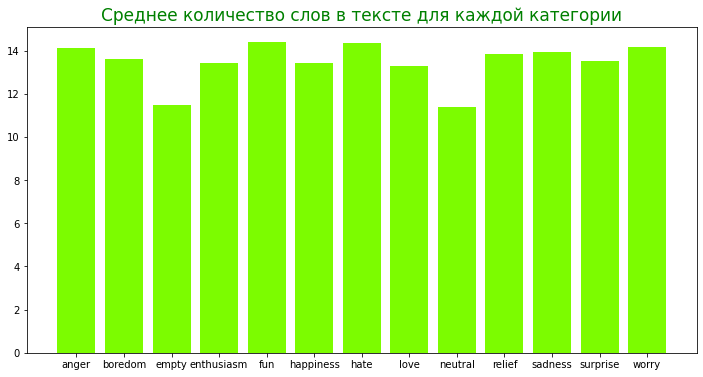

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))  # создание рабочей области

ax.set_title('Среднее количество слов в тексте для каждой категории', color = 'green', size = 17)   # названия графика
ax.bar(mean_word.index,mean_word['content'], color = 'lawngreen')

# ax.bar_label(ax.containers[0], label_type='edge')

In [55]:
mean_word['content'].mean(), mean_word['content'].max(), mean_word['content'].min()    # среднее значение слов в тексте для всего датасета

(13.45245095245531, 14.390202702702704, 11.370787822449454)

В среднем каждый текст состоит из $13-14$ слов\
Самое большое среднее количество слов у категории ```fun```, меньше всего слов в среднем у категории ```neutral```

## Разделение переменных


Разделим переменные на целевую $y$ и факторы $X$\
$y$ -- зависимая от $X$ переменная
 
Получим единственный фактор $X$, оказывающий влияние на $y$


In [56]:
y = pd.DataFrame(data['sentiment'])
X = pd.DataFrame(data['content'])
X.head()

,content
0,@tiffanylue i know i was listenin to bad habi...
1,layin n bed with a headache ughhhh...waitin o...
2,funeral ceremony...gloomy friday...
3,wants to hang out with friends soon!
4,@dannycastillo we want to trade with someone w...


In [57]:
y.head()    # целевая переменная

,sentiment
0,empty
1,sadness
2,sadness
3,enthusiasm
4,neutral


В итоге получается $1$ фактор $X$, оказывающий влияние на целевую переменную $y$

In [58]:
y['sentiment'].unique()    # все классы эмоций

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [59]:
len(y['sentiment'].unique())
# классификация на 13 классов эмоций

13

# Обработка естественного языка

> Для получения более качественных моделей и получения более точных результатов необходимо обработать текстовые данные.

Для этого:
* Удалим стоп-слова из датасета;
* Избавимся от чисел, знаков препинания и всех ненужных (незначимых) символов
* Разобьем текст на токены (токенизация);
* Проведем лемматизацию, получив нормальную (начальную) форму слова;
* Построим облако слов;

##Удаление стоп-слов





> Для начала почистим датасет от стоп-слов, которые в естественном языке не несут смысловой нагрузки и не влияют на классификацию машинного обучения. Стоп-слова игнорируются, чтобы выдать более точные результаты.

In [60]:
X.head()   # для наглядного сравнения

,content
0,@tiffanylue i know i was listenin to bad habi...
1,layin n bed with a headache ughhhh...waitin o...
2,funeral ceremony...gloomy friday...
3,wants to hang out with friends soon!
4,@dannycastillo we want to trade with someone w...


In [61]:
X = pd.DataFrame(X['content'].apply(lambda x: remove_stopwords(x))); X.head()   # удаление стоп-слов

,content
0,@tiffanylue know listenin bad habit earlier st...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"@dannycastillo want trade houston tickets, will."


Видно, что из датасета удалились стоп-слова, такие как "$i","to","we", "was","with"$ и тд. Это упростит процесс обучения и классификации модели

## Очистка от неалфавитных символов

Twitter использует разметку твитов с помощью “www”, “#” и “@”. Для более правильной классификации эмоций, необходимо предварительно обработать текст, чтобы нормализовать язык. 

Большинство твиттов -- это ответы на твитты других пользователей, поэтому они начинаются с ```@```, после чего следует имя пользователя, которому идет ответ

In [62]:
X['content'].str.startswith('@').sum()    # теги пользователей

18144

In [63]:
X['content'].str.startswith('#').sum()    # хештеги

107

In [64]:
X['content'].str.startswith('www').sum()   # ссылки на сайт

3

In [65]:
X['content'].str.startswith('https').sum()   # ссылки на сайт

0

* $18144$ твиттов начинаются с символа @, что означает ответ другому пользователю\
После символа @ следует имя пользователя. Для нас оно не важно для классификации и является лишней информацией в текстовом сообщении, поэтому все никнеймы можно удалить

* $107$ твиттов начинаются с символа ```#```, после чего идет определенный тег
* $3$ твитта начинаются с ```www```, то есть идет ссылка на сайт. Сайт также не представляет эмоцию

In [66]:
X.head()   # для наглядного сравнения

,content
0,@tiffanylue know listenin bad habit earlier st...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"@dannycastillo want trade houston tickets, will."


In [67]:
# Функция re.sub позволяет заменить все, что подходит под шаблон на указанную строку.


X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"@\w+\s?"," ",x))); X.head() 
# удаляет все слова, начинающиеся на @
# \w — заменяет любую цифру, букву, а также _
# \s — соответствует любому пробельному символу;
# "?" означает, что после слова может следовать необязательный пробел

,content
0,know listenin bad habit earlier started freak...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"want trade houston tickets, will."


In [68]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"@\s+\w?"," ",x)))
# сначала идет @, после нее пробел, а потом тег (@ name)

Данный код позволяет удалить из текста все упоминания пользователей в социальных сетях, которые начинаются с символа "@".

Удаляем все сообщение, начинающиеся с хэштегов

In [69]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"#\w+\s?"," ",x)))   # без пробельного символа: #tag
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"#\s+\w?"," ",x)))   # пробельный символ после хэштега: # tag

Удаляем все неалфавитные символы

In [70]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]"," ",x)))
# ^ - любой символ кроме перечисленных(то есть не буква алфавита)
# \s - любой пробельный символ
# удаляет любой символ из (\-:\)\\\/\];='#]

Удаляем все сообщения, содержашие ссылку на сайт

In [71]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub('www.\w+\s'," ",x)))
X = pd.DataFrame(X['content'].apply(lambda x: re.sub('www.\s+\w'," ",x)))
# re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', clean_text)

Убедимся в корректности удаления данных

In [72]:
X['content'].str.startswith('@').sum(), X['content'].str.startswith('#').sum(), X['content'].str.startswith('www').sum()

(0, 0, 0)

Теперь датасет не содержит тегов пользователей, хэштегов и ссылок на сайт

## Токенизация текста

> Для того, чтобы осуществить лемматизацию предварительно проведем токенизацию текста -- разбиение на более мелкие фрагменты (слова)

In [73]:
nltk.download('punkt')

X = pd.DataFrame(X['content'].apply(lambda x: word_tokenize(x))); X.head()   # разбивает текст на отдельные слова по пробелам в список

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


,content
0,"[know, listenin, bad, habit, earlier, started,..."
1,"[layin, n, bed, headache, ughhhh, waitin, call]"
2,"[funeral, ceremony, gloomy, friday]"
3,"[wants, hang, friends, soon]"
4,"[want, trade, houston, tickets, will]"


## **Лемматизация текста**

> Лемматизация является процессом приведения слова к его основной форме. Это позволяет упростить обработку естественного языка и улучшить качество анализа текстов.

In [75]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()   # объект класса
X = pd.DataFrame(X['content'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x]))); X.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content
0,k n o w l i s t e n i n b a d h a b i t ...
1,l a y i n n b e d h e a d a c h e u g ...
2,f u n e r a l c e r e m o n y g l o o m y ...
3,w a n t h a n g f r i e n d s o o n
4,w a n t t r a d e h o u s t o n t i c k ...


Посмотрим как изменилось среднее количество слов в наборе данных

In [77]:
words = X['content'].apply(lambda x: len(x.split())); words   # количество слов в каждой строке поля сontent

0        42
1        33
2        27
3        18
4        26
         ..
39995     0
39996    18
39997    54
39998    62
39999    73
Name: content, Length: 39862, dtype: int64

In [78]:
X_word = X.copy()
X_word['content'] = words
X_word.head()   # новый датасет, у которого текст заменен на количество слов в тексте

,content
0,42
1,33
2,27
3,18
4,26


In [79]:
mean_word = pd.DataFrame(X_word.mean()); mean_word    # среднее значение количества слов в тексте для каждой категории

,0
content,35.458607


В среднем текст содержит теперь по 8 слов

## Облако слов

>Визуализация популярности слов в виде облака, которое  показывает самые частовстречающиеся слова текста

In [94]:
text = "".join(X['content'])
 
cloud = WordCloud().generate(text)    # генерация облака слов
plt.imshow(cloud)
plt.axis('off')   # убирает разметку (шкалу измерения) у осей
plt.title('Облако слов')

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

# Преобразование текстовых данных в числовые. Векторизация текста

 Алгоритмы машинного обучения не умеют работать с текстом, поэтому для дальнейшей классификации необходимо представить текстовые данные числами. Для этого потребуется преобразовать столбцы ```content``` и ```sentiment```

## Разделение данных на тестовую и обучающую выборки

>Предварительно разделим набор данных на тестовую и обучащиеся выборки для того, чтобы в будущем при обучении моделей более точно оценить качество модели и снизить риск пере- или недо обучения модели.\
Из выборки данных отделим часть данных на обучение, оставшаяся часть данных будет использоваться для оценки качества 

In [82]:
x = X['content'].values
y = y['sentiment'].values
x, y   # получение значений, каждое предложение/категория отдельным элементом списка

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Поскольку мы имеем всего 13 уникальных классов для переменной $y$, можно произвести кодирование целевой переменной при помощи ```LabelEncoder```, который преобразует каждую категорию в числа от $1$ до числа, равного количеству категорий (то есть до &13&). Применим его к целевой переменной.

In [83]:
dict_emotion = {i: np.unique(y)[i] for i in range(13)}
dict_emotion    # словарь соотношения категории и его номера

{0: 'anger',
 1: 'boredom',
 2: 'empty',
 3: 'enthusiasm',
 4: 'fun',
 5: 'happiness',
 6: 'hate',
 7: 'love',
 8: 'neutral',
 9: 'relief',
 10: 'sadness',
 11: 'surprise',
 12: 'worry'}

In [84]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)    # всевозможные уникальные значения переменной y
y, encoder.classes_   # всевозможные уникальные значения y

(array([ 2, 10, 10, ...,  7,  5,  7]),
 array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
        'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
        'worry'], dtype=object))

In [85]:
# произведем разбиение выборки на тестовую и обучающуюся

X_train, X_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.25, # проентная доля объема тестовой выборки от всего объема выборки
    random_state=42    # рандомное распределение данных по выборкам
    )

In [86]:
X_train.shape, X_test.shape

((29896,), (9966,))

Модель обучается на $29896$ примерах, оставшиеся $9966$ идут на тестирование и оценку качества/производительности модели



Визаулизируем распределение тестовой и обучающейся выборки по категориям

In [87]:
y_train_val = pd.DataFrame(y_train).value_counts().sort_index()
y_test_val = pd.DataFrame(y_test).value_counts().sort_index()
index = y_train_val.index
index = [dict_emotion[i] for i in range(13)]
y_train_val, y_test_val

(0       84
 1      139
 2      591
 3      574
 4     1345
 5     3879
 6      985
 7     2841
 8     6448
 9     1140
 10    3847
 11    1683
 12    6340
 dtype: int64,
 0       26
 1       40
 2      235
 3      185
 4      431
 5     1304
 6      338
 7      946
 8     2158
 9      384
 10    1308
 11     503
 12    2108
 dtype: int64)

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

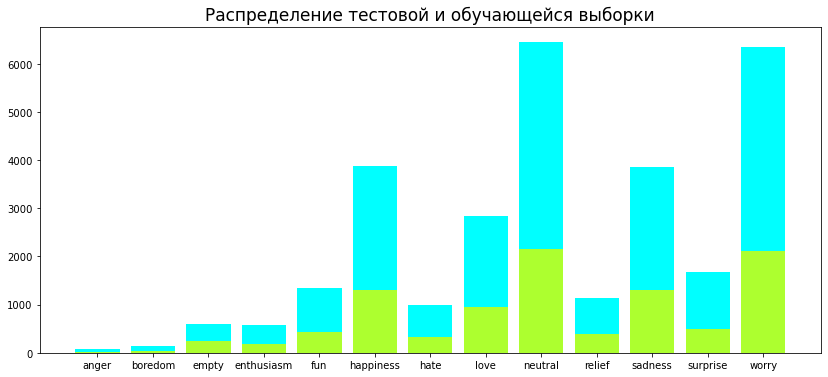

In [88]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,6))  # создание рабочей области

ax.set_title('Распределение тестовой и обучающейся выборки', color = 'black', size = 17)   # названия графика
ax.bar(index, y_train_val, color = 'cyan')
ax.bar(index, y_test_val, color = 'greenyellow')
# ax.bar_label(ax.containers[0], label_type='edge')
# ax.bar_label(ax.containers[1], label_type='edge')

## Векторизация текста 





> Осуществим преобразование данных при помощи ```TfidfVectorizer```, который оценивает частоту появления как в отдельных фрагментах текста, так и во всем тексте,  а также при помощи ```CountVectorizer```, который  в матрицу количества токенов

In [89]:
%%time

vectorizer = TfidfVectorizer()   # объект класса
x_train_tf = vectorizer.fit_transform(X_train).toarray()   # преобразование данных + обучение для обучaющихся данных
x_test_tf = vectorizer.transform(X_test).toarray()      # только преобразование для тестовых данных

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [90]:
%%time

vectorizer = CountVectorizer()   # объект класса 
x_train_cv = vectorizer.fit_transform(X_train).toarray()   # преобразование данных + обучение для обучaющихся данных
x_test_cv = vectorizer.transform(X_test).toarray()      # только преобразование для тестовых данных

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [91]:
x_train_tf, x_test_cv    # представление текста в виде числовой матрицы

NameError: name 'x_train_tf' is not defined

При обучении моделей будем применять данные, векторизированные обоими способами

# Построение моделей классификации

In [92]:
# словарь со всеми полученными метриками точности для дальнейшего сравнения моделей

metrics = pd.DataFrame(columns = ['Logistic Regression', 'Random Forest', 'SVM', 'Neighbors', 'MLP', 'Tree', 'Gaussian', 'Passive Agressive', 'Ridge', 'Begging'], 
                       index = ['accuracy_score'])

## Логистическая регрессия ```LogisticRegression```

> ```TfdifVectorizer```

In [93]:
%%time

lr1 = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter=500000))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
lr1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_tf = lr1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = lr1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

ValueError: empty vocabulary; perhaps the documents only contain stop words

На основе полученных результатов точностей моделей можно сделать вывод о недообучении модели, поскольку значение метрики точности обучающейся выборки довольно низкое. Модель делает верный прогноз с точностью ~35%

In [ ]:
from yellowbrick.model_selection import LearningCurve

x_ = np.vstack((x_train_tf, x_test_tf))
y_ = np.hstack((y_train, y_test))
visualizer = LearningCurve(
    LogisticRegression(max_iter=500000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.25      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.13      0.01      0.02       431
           5       0.34      0.35      0.34      1304
           6       0.40      0.12      0.18       338
           7       0.47      0.39      0.43       946
           8       0.34      0.57      0.43      2158
           9       0.31      0.03      0.05       384
          10       0.33      0.22      0.27      1308
          11       0.23      0.03      0.06       503
          12       0.34      0.50      0.40      2108

    accuracy                           0.35      9966
   macro avg       0.24      0.17      0.17      9966
weighted avg       0.33      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

lr2 = Pipeline([('cv', CountVectorizer()), ('lr', LogisticRegression(max_iter=500000))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
lr2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_cv = lr2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = lr2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 70.1%
Test score: 33.29%
Time fit: 34.38 s
CPU times: user 28.8 s, sys: 32.8 s, total: 1min 1s
Wall time: 34.8 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

Видим значительную разницу между результатми тестовой и обучающейся выборок => можем предположить, что модель переобучилась

Модель ```TfdifVectorizer``` показала результаты лучше\
Посмотрим на другие метрики для этой модели

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_tf, labels = [j for j in range(13)])[i]
    for i in range(13)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'anger': array([[9940,    0],
        [  26,    0]]),
 'boredom': array([[9926,    0],
        [  40,    0]]),
 'empty': array([[9728,    3],
        [ 234,    1]]),
 'enthusiasm': array([[9781,    0],
        [ 185,    0]]),
 'fun': array([[9502,   33],
        [ 426,    5]]),
 'happiness': array([[7773,  889],
        [ 848,  456]]),
 'hate': array([[9567,   61],
        [ 298,   40]]),
 'love': array([[8604,  416],
        [ 577,  369]]),
 'neutral': array([[5438, 2370],
        [ 923, 1235]]),
 'relief': array([[9560,   22],
        [ 374,   10]]),
 'sadness': array([[8078,  580],
        [1019,  289]]),
 'surprise': array([[9406,   57],
        [ 486,   17]]),
 'worry': array([[5798, 2060],
        [1055, 1053]])}

<Axes: >

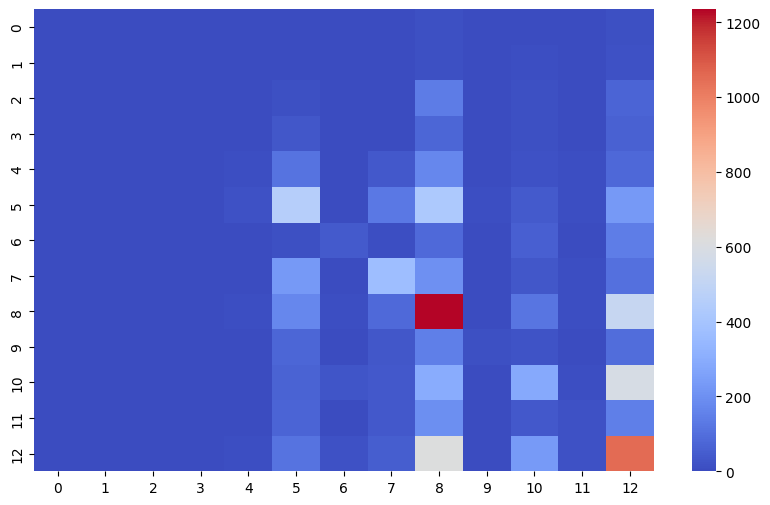

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_tf),cmap="coolwarm")

In [ ]:
# модель TFIDF показали результаты лучше, поэтому добавляе ее значения метрик м в итоговый датафрэйм 
metrics['Logistic Regression']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками

Сложность устройства данных выше, чем сложность устройства модели ```LogisticRegression```, поэтому модель недобучается. Построим более сложные модели

## Случайный лес ```RandomForest```

> ```TfdifVectorizer```

In [ ]:
%%time

rf1 = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', RandomForestClassifier(random_state = 42))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
rf1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_tf = rf1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = rf1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 98.05%
Test score: 34.22%
Time fit: 154.81 s
CPU times: user 2min 42s, sys: 388 ms, total: 2min 43s
Wall time: 2min 43s


Разница в показаниях тестовой и обучающейся выборок большая, то есть модель переобучилась

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.20      0.03      0.06       431
           5       0.31      0.33      0.32      1304
           6       0.37      0.17      0.23       338
           7       0.45      0.42      0.43       946
           8       0.33      0.56      0.42      2158
           9       0.21      0.03      0.05       384
          10       0.37      0.22      0.28      1308
          11       0.24      0.05      0.08       503
          12       0.34      0.47      0.39      2108

    accuracy                           0.34      9966
   macro avg       0.22      0.17      0.17      9966
weighted avg       0.32      0.34      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

rf2 = Pipeline([('cv', CountVectorizer()), ('classifier', RandomForestClassifier(random_state = 42))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
rf2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_cv = rf2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = rf2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 98.06%
Test score: 31.879999999999995%
Time fit: 169.86 s
CPU times: user 2min 57s, sys: 555 ms, total: 2min 57s
Wall time: 2min 57s


Видим значительную разницу между результатми тестовой и обучающейся выборок => модель тоже переобучилась

Результаты ```TfidfVectorizer``` оказались лучше

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_tf, labels = [j for j in range(13)])[i]
    for i in range(13)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'anger': array([[9940,    0],
        [  26,    0]]),
 'boredom': array([[9923,    3],
        [  40,    0]]),
 'empty': array([[9711,   20],
        [ 235,    0]]),
 'enthusiasm': array([[9773,    8],
        [ 185,    0]]),
 'fun': array([[9478,   57],
        [ 417,   14]]),
 'happiness': array([[7698,  964],
        [ 870,  434]]),
 'hate': array([[9531,   97],
        [ 282,   56]]),
 'love': array([[8529,  491],
        [ 552,  394]]),
 'neutral': array([[5398, 2410],
        [ 954, 1204]]),
 'relief': array([[9537,   45],
        [ 372,   12]]),
 'sadness': array([[8179,  479],
        [1021,  287]]),
 'surprise': array([[9389,   74],
        [ 479,   24]]),
 'worry': array([[5950, 1908],
        [1123,  985]])}

<Axes: >

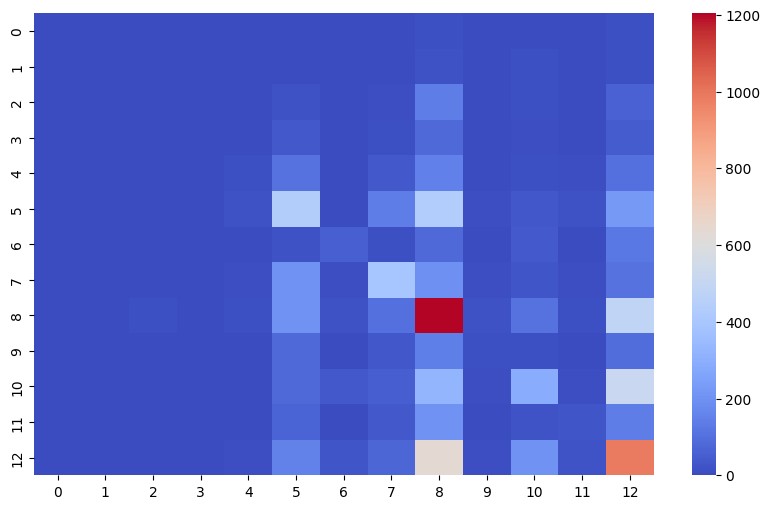

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_tf),cmap="coolwarm")

In [ ]:
print(f1_score(y_test, y_pred_tf, average = 'micro'))     #  Гармоническое среднее значение 77 и отзыва (Отзыв = истинно положительный / (истинно положительный + ложноотрицательный))

0.34216335540838855


In [ ]:
# модель TFIDF показали результаты лучше, поэтому добавляе ее значения метрик м в итоговый датафрэйм 
metrics['Random Forest']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками

Для борьбы с переобчением модели попробуем использовать методы *регуляризации*

##Метод опорных векторов

> ```TfdifVectorizer```

In [ ]:
%%time

svm1 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_tf = svm1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = svm1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 74.56%
Test score: 35.35%
Time fit: 244.53 s
CPU times: user 6min 18s, sys: 369 ms, total: 6min 18s
Wall time: 6min 18s


Значение метрики точности у этой модели чуть больше, но по-прежнему низкое. Модель недообучена

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.33      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.17      0.00      0.00       431
           5       0.35      0.33      0.34      1304
           6       0.45      0.13      0.20       338
           7       0.48      0.39      0.43       946
           8       0.33      0.62      0.43      2158
           9       0.31      0.01      0.03       384
          10       0.41      0.16      0.23      1308
          11       0.45      0.02      0.04       503
          12       0.34      0.53      0.42      2108

    accuracy                           0.35      9966
   macro avg       0.28      0.17      0.16      9966
weighted avg       0.35      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

svm2 = Pipeline([('cv', CountVectorizer()),  ('clf', svm.SVC())])   # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_cv = svm2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = svm2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 67.86999999999999%
Test score: 35.54%
Time fit: 225.16 s
CPU times: user 5min 58s, sys: 310 ms, total: 5min 58s
Wall time: 5min 58s


```CountVectorizer``` показал результат лучше

In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.33      0.00      0.01       431
           5       0.32      0.35      0.34      1304
           6       0.52      0.14      0.22       338
           7       0.49      0.36      0.42       946
           8       0.34      0.63      0.44      2158
           9       0.25      0.01      0.02       384
          10       0.41      0.18      0.25      1308
          11       0.33      0.02      0.03       503
          12       0.34      0.52      0.41      2108

    accuracy                           0.36      9966
   macro avg       0.26      0.17      0.16      9966
weighted avg       0.35      0.36      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
conf_matrix2 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_cv, labels = [j for j in range(13)])[i]
    for i in range(13)
}
conf_matrix2    #  матрица ошибок для каждого класса для мультиклассовой классификации

{'anger': array([[9940,    0],
        [  26,    0]]),
 'boredom': array([[9926,    0],
        [  40,    0]]),
 'empty': array([[9731,    0],
        [ 235,    0]]),
 'enthusiasm': array([[9781,    0],
        [ 185,    0]]),
 'fun': array([[9531,    4],
        [ 429,    2]]),
 'happiness': array([[7689,  973],
        [ 842,  462]]),
 'hate': array([[9584,   44],
        [ 290,   48]]),
 'love': array([[8656,  364],
        [ 601,  345]]),
 'neutral': array([[5210, 2598],
        [ 802, 1356]]),
 'relief': array([[9573,    9],
        [ 381,    3]]),
 'sadness': array([[8324,  334],
        [1077,  231]]),
 'surprise': array([[9445,   18],
        [ 494,    9]]),
 'worry': array([[5778, 2080],
        [1022, 1086]])}

<Axes: >

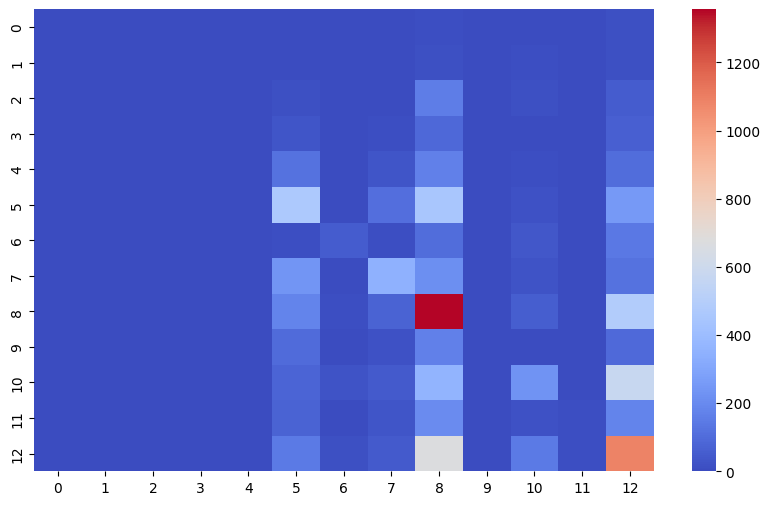

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cv),cmap="coolwarm")

In [ ]:
print(f1_score(y_test, y_pred_cv, average = 'micro'))     #  Гармоническое среднее значение 77 и отзыва (Отзыв = истинно положительный / (истинно положительный + ложноотрицательный))

0.3554083885209713


In [ ]:
# модель TFIDF показали результаты лучше, поэтому добавляе ее значения метрик м в итоговый датафрэйм 
metrics['SVM']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками
metrics['SVM']['f1_score'] = round(f1_score(y_test, y_pred_tf, average = 'micro'),4)*100   

## Метод ближайших соседей

> ```TfdifVectorizer```

In [ ]:
%%time

svm1 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', svm.SVC())])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_tf = svm1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = svm1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 74.56%
Test score: 35.35%
Time fit: 245.3 s
CPU times: user 6min 18s, sys: 339 ms, total: 6min 18s
Wall time: 6min 18s


Значение метрики у жтой модели чуть больше

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.33      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.17      0.00      0.00       431
           5       0.35      0.33      0.34      1304
           6       0.45      0.13      0.20       338
           7       0.48      0.39      0.43       946
           8       0.33      0.62      0.43      2158
           9       0.31      0.01      0.03       384
          10       0.41      0.16      0.23      1308
          11       0.45      0.02      0.04       503
          12       0.34      0.53      0.42      2108

    accuracy                           0.35      9966
   macro avg       0.28      0.17      0.16      9966
weighted avg       0.35      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

svm2 = Pipeline([('cv', CountVectorizer()),  ('clf', svm.SVC())])   # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
y_pred_cv = svm2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = svm2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных, 
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {round(end_time - start_time, 2)} s')

Training score: 67.86999999999999%
Test score: 35.54%
Time fit: 226.55 s
CPU times: user 5min 59s, sys: 343 ms, total: 5min 59s
Wall time: 5min 59s


```CountVectorizer``` показал результат лучше

##Многослойный перцептрон

##Дерево решений

##Наивный байесовский классификатор

##Пассивно -агрессивный классификатор

##Гребневый классификатор

##Polynomyal Logistic Regreddio